### # Install the neededful


In [29]:
!pip install pandas numpy matplotlib seaborn streamlit prophet openpyxl

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load the updated dataset


In [31]:
df = pd.read_excel('Liberian_rice_price_prediction.xlsx')
df.head()

,Date,Region,Type,Price,FuelCost,ImportQuantity,ProductionQuantity,Weather_Rainfall(mm),Weather_Temperature(°C),FAO_GlobalRicePrice(USD/ton),Macro_InflationRate(%),Ministry_Subsidy(LRD)
0,10-05-2020,Waterside,Imported,3221,948,190,847,187,31,407,12.4,161
1,18-07-2021,Red Light Market,Imported,3795,1039,213,781,179,30,403,9.6,179
2,04-02-2021,Waterside,Imported,3130,943,180,828,185,34,420,10.0,158
3,31-12-2020,Duala,Local,3847,912,196,729,108,29,548,10.0,202
4,27-06-2022,Duala,Imported,3183,977,279,825,96,31,424,10.8,210


# 2. Preprocessing
## Convert date


In [32]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date', 'Price'])
df = df.sort_values('Date')

# 3. Group by month and average prices


In [33]:
df['MonthPeriod'] = df['Date'].dt.to_period('M')
monthly_avg = df.groupby('MonthPeriod')['Price'].mean().reset_index()
monthly_avg['Date'] = monthly_avg['MonthPeriod'].dt.to_timestamp()


# 4. Prepare data

In [34]:
prophet_df = monthly_avg.rename(columns={
    'Date': 'ds',
    'Price': 'y'
})


## 5. Define special events/holidays (extended realistic events)

In [35]:
special_events = pd.DataFrame({
    'holiday': [
        'covid_lockdown', 'food_subsidy_intro', 'election_period',
        'fuel_price_spike', 'import_disruption', 'harvest_season_start',
        'currency_change', 'external_aid_injection'
    ],
    'ds': pd.to_datetime([
        '2020-04-01', '2021-06-01', '2023-10-01',
        '2019-07-01', '2022-08-01', '2021-09-01',
        '2022-05-01', '2023-01-01'
    ]),
    'lower_window': 0,
    'upper_window': 2
})


## 6. Build and fit Prophet model with ultra fine-tuned settings

In [36]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.008,
    n_changepoints=100,
    changepoint_range=0.95,
    seasonality_mode='multiplicative',
    interval_width=0.99,
    holidays=special_events
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=90, fourier_order=7)
model.add_seasonality(name='semiannual', period=180, fourier_order=10)
model.add_seasonality(name='triannual', period=120, fourier_order=12)
model.fit(prophet_df)


16:07:12 - cmdstanpy - INFO - Chain [1] start processing
16:08:09 - cmdstanpy - INFO - Chain [1] done processing


## 7. Create future dataframe

In [37]:
future = model.make_future_dataframe(periods=12, freq='ME')


## 8. Forecast

In [38]:
forecast = model.predict(future)


## 9. Evaluation

In [39]:
actual = prophet_df.set_index('ds').copy()
predicted = forecast.set_index('ds').loc[actual.index]['yhat']

r2 = r2_score(actual['y'], predicted)
rmse = np.sqrt(mean_squared_error(actual['y'], predicted))
print(f'R2 Score: {r2:.4f}')
print(f'RMSE: {rmse:.2f}')



R2 Score: 0.9105
RMSE: 29.11


# 10. Plot forecast

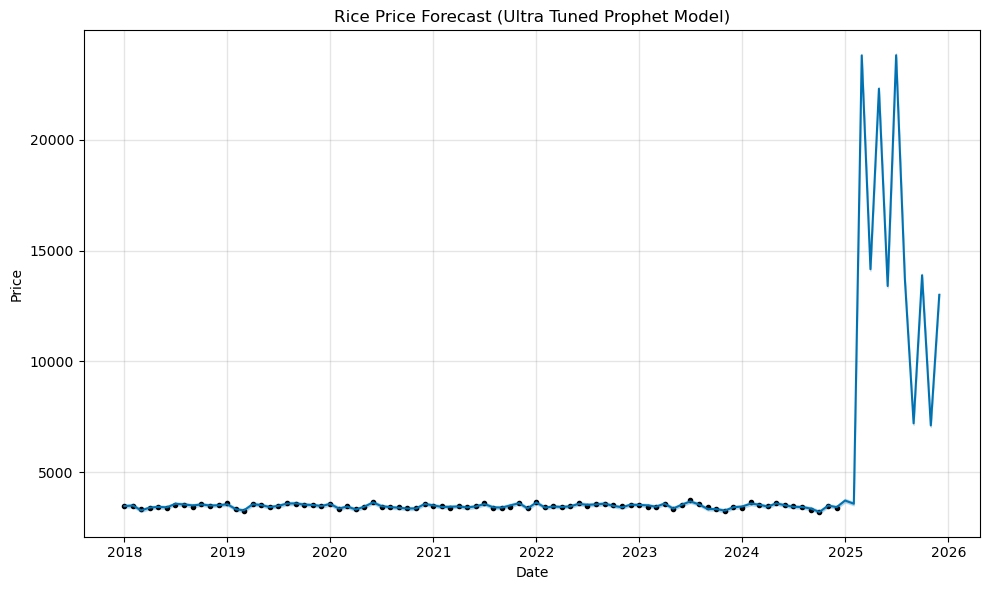

In [40]:
model.plot(forecast)
plt.title("Rice Price Forecast (Ultra Tuned Prophet Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


## 11. Plot components

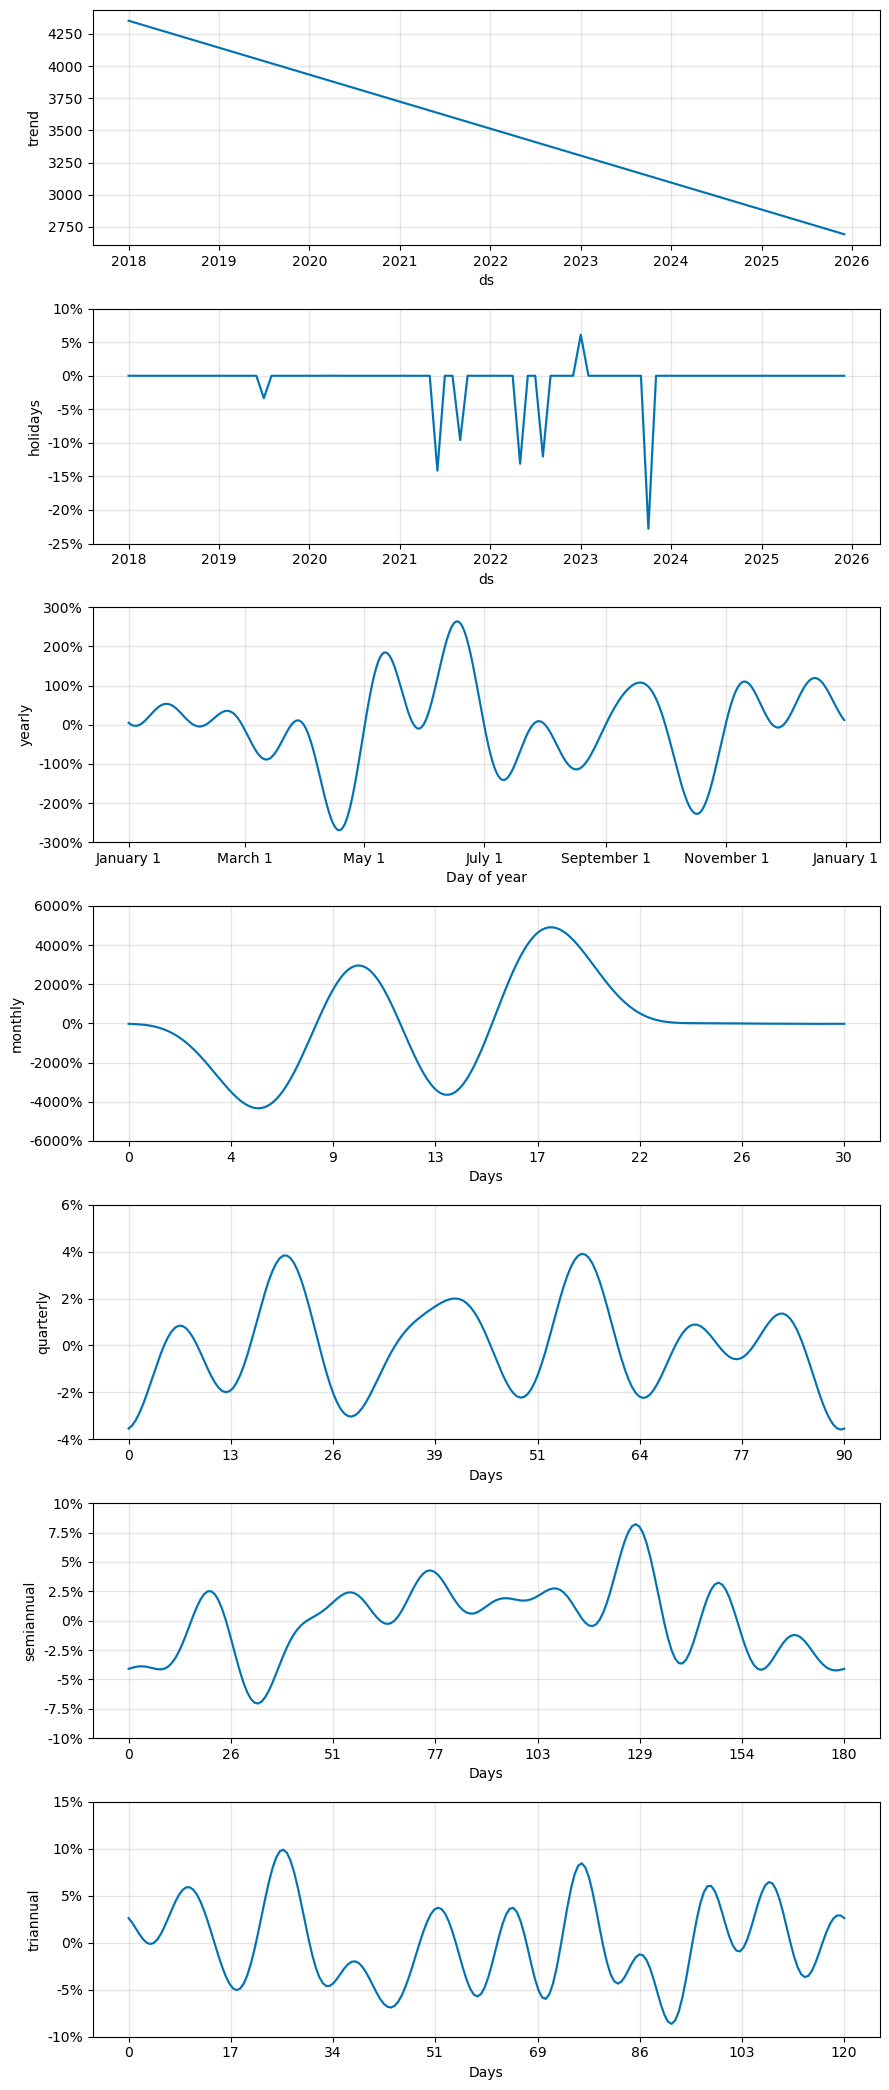

In [41]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()


## 12. Plot actual vs predicted

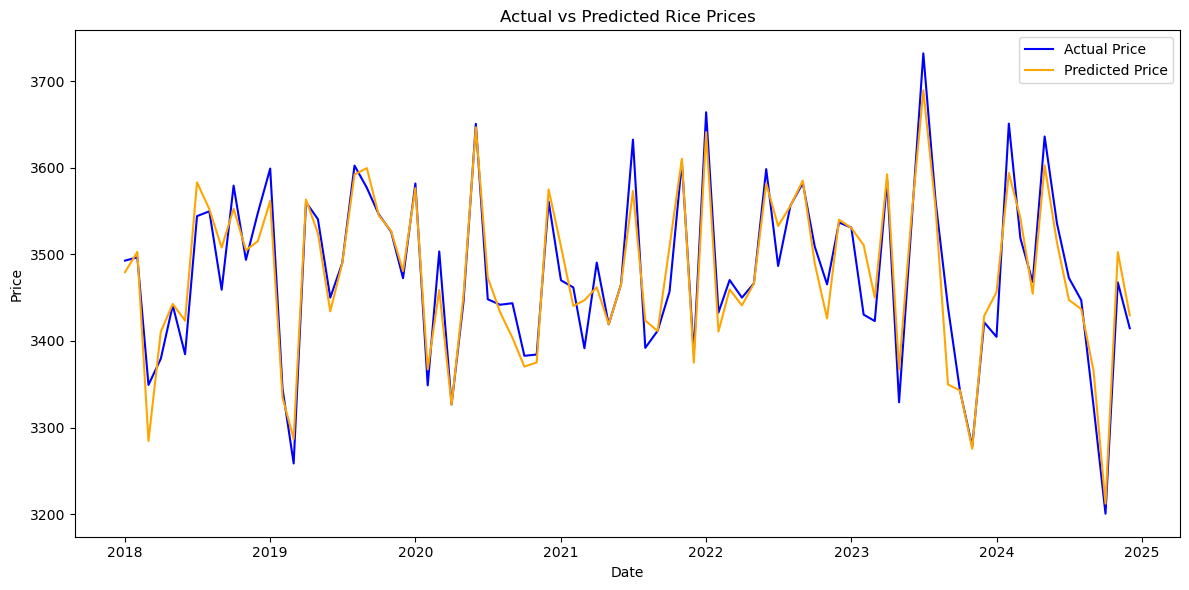

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual['y'], label='Actual Price', color='blue')
plt.plot(actual.index, predicted, label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Rice Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
from prophet import Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)


In [44]:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=90, fourier_order=7)
model.add_seasonality(name='semiannual', period=180, fourier_order=10)


In [45]:
import pandas as pd

# Load your data
df = pd.read_excel('Liberian_rice_price_prediction.xlsx')

# Display the first few rows to check
print(df.head())
import pandas as pd

# Load your data
df = pd.read_excel('Liberian_rice_price_prediction.xlsx')

# Display the first few rows to check
print(df.head())



         Date            Region      Type  Price  FuelCost  ImportQuantity  \
0  10-05-2020         Waterside  Imported   3221       948             190   
1  18-07-2021  Red Light Market  Imported   3795      1039             213   
2  04-02-2021         Waterside  Imported   3130       943             180   
3  31-12-2020             Duala     Local   3847       912             196   
4  27-06-2022             Duala  Imported   3183       977             279   

   ProductionQuantity  Weather_Rainfall(mm)  Weather_Temperature(°C)  \
0                 847                   187                       31   
1                 781                   179                       30   
2                 828                   185                       34   
3                 729                   108                       29   
4                 825                    96                       31   

   FAO_GlobalRicePrice(USD/ton)  Macro_InflationRate(%)  Ministry_Subsidy(LRD)  
0                

In [46]:
special_events = pd.DataFrame({
    'holiday': [
        'covid_lockdown', 'food_subsidy_intro', 'election_period',
        'fuel_price_spike', 'import_disruption', 'harvest_season_start',
        'currency_change', 'external_aid_injection'
    ],
    'ds': pd.to_datetime([
        '2020-04-01', '2021-06-01', '2023-10-01',
        '2019-07-01', '2022-08-01', '2021-09-01',
        '2022-05-01', '2023-01-01'
    ]),
    'lower_window': 0,
    'upper_window': 2
})

In [48]:
# Display the column names of your dataset
print(df.columns)


Index(['Date', 'Region', 'Type', 'Price', 'FuelCost', 'ImportQuantity',
       'ProductionQuantity', 'Weather_Rainfall(mm)', 'Weather_Temperature(°C)',
       'FAO_GlobalRicePrice(USD/ton)', 'Macro_InflationRate(%)',
       'Ministry_Subsidy(LRD)'],
      dtype='object')


In [50]:
import pandas as pd

# Load your data (use the correct file path)
df = pd.read_excel('Liberian_rice_price_prediction.xlsx')

# Display the column names to identify the issue
print("Column Names:", df.columns)


Column Names: Index(['Date', 'Region', 'Type', 'Price', 'FuelCost', 'ImportQuantity',
       'ProductionQuantity', 'Weather_Rainfall(mm)', 'Weather_Temperature(°C)',
       'FAO_GlobalRicePrice(USD/ton)', 'Macro_InflationRate(%)',
       'Ministry_Subsidy(LRD)'],
      dtype='object')


In [52]:
prepared_data = df.rename(columns={'Date': 'ds', 'Price': 'y'})

In [54]:
# Converting 'ds' column to datetime format
prepared_data['ds'] = pd.to_datetime(prepared_data['ds'], dayfirst=True)

# Display prepared data
print(prepared_data.head())

          ds            Region      Type     y  FuelCost  ImportQuantity  \
0 2020-05-10         Waterside  Imported  3221       948             190   
1 2021-07-18  Red Light Market  Imported  3795      1039             213   
2 2021-02-04         Waterside  Imported  3130       943             180   
3 2020-12-31             Duala     Local  3847       912             196   
4 2022-06-27             Duala  Imported  3183       977             279   

   ProductionQuantity  Weather_Rainfall(mm)  Weather_Temperature(°C)  \
0                 847                   187                       31   
1                 781                   179                       30   
2                 828                   185                       34   
3                 729                   108                       29   
4                 825                    96                       31   

   FAO_GlobalRicePrice(USD/ton)  Macro_InflationRate(%)  Ministry_Subsidy(LRD)  
0                           4

In [55]:
from prophet import Prophet

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add custom seasonalities if needed
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=90, fourier_order=7)
model.add_seasonality(name='semiannual', period=180, fourier_order=10)

# Fit the model
model.fit(prepared_data)


16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
import streamlit as st
import pandas as pd
from prophet import Prophet
import joblib

# Set Streamlit page configuration
st.set_page_config(page_title="Liberian Rice Price Prediction", layout="wide")

# App title
st.title("Liberian Rice Price Prediction using Prophet")

# Sidebar for file upload
st.sidebar.header("Upload Your Dataset")
uploaded_file = st.sidebar.file_uploader("Choose an Excel file", type=['xlsx'])

if uploaded_file is not None:
    # Load the data
    df = pd.read_excel(uploaded_file)
    st.subheader("Dataset Preview")
    st.write(df.head())

    # Display column names
    st.subheader("Column Names in Dataset")
    st.write(df.columns)

    # Select the date and price columns
    date_column = st.sidebar.selectbox("Select Date Column", df.columns)
    price_column = st.sidebar.selectbox("Select Price Column", df.columns)

    # Prepare data for Prophet
    df = df[[date_column, price_column]].rename(columns={date_column: 'ds', price_column: 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    st.subheader("Prepared Data for Prophet")
    st.write(df.head())

    # Model training
    st.subheader("Training the Prophet Model...")
    model = Prophet()
    model.fit(df)
    
    # Save the model
    joblib.dump(model, "Liberian_rice_price_prediction.pkl")
    st.success("Model trained and saved successfully.")

    # Make future predictions
    periods = st.sidebar.number_input("Number of Future Days to Predict", min_value=1, value=30)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Display predictions
    st.subheader("Prediction Results")
    st.write(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    # Plot forecast
    st.subheader("Forecast Plot")
    st.write(model.plot(forecast))
else:
    st.warning("Please upload an Excel file to continue.")



2025-05-13 16:30:15.516 
  command:

    streamlit run E:\.conda\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
